# Setup

In [ ]:
import pandas as pd
import numpy as np

# Instructions can be found here: https://drive.google.com/file/d/1CQjb0nyx6AlzYp2LQcnBeLMPBYLlhJwV/view?usp=sharing
# Reading in the test and train employee survey data
train_df = pd.read_csv('C:/Users/Fullstack1/Documents/Cours/2022-2023 M1 QESS/Artificial intelligence & Social sciences/AIandSHS/train.csv', low_memory=False) # p-ê ajouter en dernier paramètre , na_values="?"
# For low_memory argument https://stackoverflow.com/a/33161955 ; for na_values see "Visualizing scikit-learn pipelines in Jupyter" and https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_ames_housing.html
test_df = pd.read_csv('C:/Users/Fullstack1/Documents/Cours/2022-2023 M1 QESS/Artificial intelligence & Social sciences/AIandSHS/test.csv', na_values="?")

#Initial modifications of the data

target_column = "ANNUAL"
numerical_columns = [
    "AGY",
    "RATE",
    "HRSWKD",
]
categorical_columns = [
    "NAME",
    # "MI", # it's probably "Middle initial", so useless
    "JOBCLASS",
    "JC.TITLE",
    "RACE",
    "SEX",
    "EMPTYPE",
    "HIREDT",
    "STATENUM",
    "multiple_full_time_jobs",
    "combined_multiple_jobs",
]
all_columns = numerical_columns + categorical_columns + [target_column]

train_df = train_df[all_columns]

# Selection of columns for data and target
data = train_df.drop(columns=[target_column, ])
target = train_df[target_column]


# Dealing with missing values for data
#data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median()) # replace NaNs with column medians

from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="constant", fill_value=False)
data[["multiple_full_time_jobs", "combined_multiple_jobs"]] = imp.fit_transform(data[["multiple_full_time_jobs", "combined_multiple_jobs"]])
data['multiple_full_time_jobs'] = data['multiple_full_time_jobs'].replace({True: 'Yes', False: 'No'})
data['combined_multiple_jobs'] = data['combined_multiple_jobs'].replace({True: 'Yes', False: 'No'})

# Creation of the pipeline with HistGradientBoostingRegressor

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)

preprocessor = ColumnTransformer(
    [("categorical", categorical_preprocessor, categorical_columns)],
    remainder="passthrough",
)

model_hist = make_pipeline(preprocessor, HistGradientBoostingRegressor(max_iter=200, early_stopping=True, random_state=0))

# 1) First approach: hyperparameter tuning by randomized-search

## 1.a) Inner cross-validation to optimize the hyperparameters

In [ ]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    #"n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "histgradientboostingregressor__max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "histgradientboostingregressor__learning_rate": loguniform(0.01, 1),
}
random_search_cv = RandomizedSearchCV(
    model_hist, # HistGradientBoostingRegressor(early_stopping=True),
    param_distributions=param_distributions,
    scoring="neg_mean_absolute_error",
    n_iter=10,
    random_state=0,
    n_jobs=2,
)

In [ ]:
random_search_cv.fit(data, target)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('categorical',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['NAME',
                                                                                'JOBCLASS',
                                                                                'JC.TITLE',
                                                                                'RACE',
                                                                                'SEX',
                                                                                'EMPTYPE',
                                                                                'HIREDT',
                                                                                'STATENUM',
                                                                                'multiple_full_time_jobs',
                                                                                'combined_multiple_jobs'])])),
                                             ('histgradientbo...
                                              HistGradientBoostingRegressor(early_stopping=True,
                                                                            max_iter=200,
                                                                            random_state=0))]),
                   n_jobs=2,
                   param_distributions={'histgradientboostingregressor__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000018222595430>,
                                        'histgradientboostingregressor__max_leaf_nodes': [2,
                                                                                          5,
                                                                                          10,
                                                                                          20,
                                                                                          50,
                                                                                          100]},
                   random_state=0, scoring='neg_mean_absolute_error')

## 1.b) Outer cross-validation to estimate the testing error of the tuned model

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
cv_results = cross_validate(
    random_search_cv, data, target, cv=cv, scoring="neg_mean_absolute_error"
)

In [ ]:
# To find the best values of the hyperparameters
pd.DataFrame(random_search_cv.cv_results_).drop(["mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time", "params"], axis=1).sort_values("mean_test_score", ascending=False).head()

,param_histgradientboostingregressor__learning_rate,param_histgradientboostingregressor__max_leaf_nodes,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.125207,100,-5585.899178,-5836.490810,-5508.703132,-5387.446605,-6075.499531,-5678.807851,246.855106,1
1,0.488126,20,-6220.483257,-6247.357607,-6017.178588,-5956.992854,-7271.047150,-6342.611891,477.616936,2
5,0.845913,10,-6595.150396,-6761.224711,-6216.957439,-6194.283025,-7352.216163,-6623.966347,424.335250,3
3,0.176656,10,-7153.734201,-7278.575966,-6948.523473,-7368.652840,-8673.453037,-7484.587903,610.919211,4
2,0.122961,5,-9125.635232,-9178.501564,-8794.810186,-9075.733937,-11196.976952,-9474.331574,871.463255,5


In [ ]:
cv_results = pd.DataFrame(cv_results)
cv_results["test_error"] = -cv_results["test_score"]
cv_results.head(5)

,fit_time,score_time,test_score,test_error
0,51.964484,0.369088,-5731.839358,5731.839358
1,54.088883,0.249616,-5948.742265,5948.742265
2,46.239920,0.290968,-5856.015095,5856.015095


In [ ]:
print(
    "The mean cross-validated testing error is: "
    f"{cv_results['test_error'].mean():.2f} k$"
)
print(
    "The standard deviation of the testing error is: "
    f"{cv_results['test_error'].std():.2f} k$"
)

The mean cross-validated testing error is: 5845.53 k$
The standard deviation of the testing error is: 108.83 k$


# 2) Second approach: hyperparameter tuning by grid-search

## 2.a) Inner cross-validation to optimize the hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    "histgradientboostingregressor__max_depth": [3, 8],
    "histgradientboostingregressor__max_leaf_nodes": [15, 31],
    "histgradientboostingregressor__learning_rate": [0.1, 1],
}

grid_search_cv = GridSearchCV(model_hist, params)

In [ ]:
grid_search_cv.fit(data, target)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['NAME',
                                                                          'JOBCLASS',
                                                                          'JC.TITLE',
                                                                          'RACE',
                                                                          'SEX',
                                                                          'EMPTYPE',
                                                                          'HIREDT',
                                                                          'STATENUM',
                                                                          'multiple_full_time_jobs',
                                                                          'combined_multiple_jobs'])])),
                                       ('histgradientboostingregressor',
                                        HistGradientBoostingRegressor(early_stopping=True,
                                                                      max_iter=200,
                                                                      random_state=0))]),
             param_grid={'histgradientboostingregressor__learning_rate': [0.1,
                                                                          1],
                         'histgradientboostingregressor__max_depth': [3, 8],
                         'histgradientboostingregressor__max_leaf_nodes': [15,
                                                                           31]})

## 2.b) Outer cross-validation to estimate the testing error of the tuned model

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

cv_grid = KFold(n_splits=5, shuffle=True, random_state=0)
cv_grid_results = cross_validate(
    grid_search_cv, data, target, cv=cv_grid, return_estimator=True, scoring="neg_mean_absolute_error"
)

In [ ]:
# To find the best values of the hyperparameters
pd.DataFrame(grid_search_cv.cv_results_).drop(["mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time", "params"], axis=1).sort_values("mean_test_score", ascending=False).head()

,param_histgradientboostingregressor__learning_rate,param_histgradientboostingregressor__max_depth,param_histgradientboostingregressor__max_leaf_nodes,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.1,8,31,0.845413,0.847049,0.820707,0.770773,0.552708,0.767330,0.110793,1
7,1,8,31,0.819423,0.816096,0.790549,0.740270,0.560647,0.745397,0.096619,2
6,1,8,15,0.795300,0.827508,0.789853,0.790284,0.487058,0.738001,0.126245,3
2,0.1,8,15,0.825877,0.819220,0.798020,0.745863,0.486766,0.735149,0.127327,4
4,1,3,15,0.797735,0.813656,0.812368,0.740385,0.472954,0.727419,0.130014,5


In [ ]:
cv_grid_results = pd.DataFrame(cv_grid_results)
cv_grid_results["test_error"] = -cv_grid_results["test_score"]
cv_grid_results.head(5)

,fit_time,score_time,estimator,test_score,test_error
0,58.492760,0.193298,GridSearchCV(estimator=Pipeline(steps=[('colum...,-6682.603648,6682.603648
1,61.016234,0.203875,GridSearchCV(estimator=Pipeline(steps=[('colum...,-6767.289082,6767.289082
2,61.785283,0.188250,GridSearchCV(estimator=Pipeline(steps=[('colum...,-6457.933422,6457.933422
3,60.338220,0.261263,GridSearchCV(estimator=Pipeline(steps=[('colum...,-6842.160579,6842.160579
4,62.674114,0.188245,GridSearchCV(estimator=Pipeline(steps=[('colum...,-6727.041356,6727.041356


In [ ]:
print(
    "The mean cross-validated testing error is: "
    f"{cv_grid_results['test_error'].mean():.2f} k$"
)
print(
    "The standard deviation of the testing error is: "
    f"{cv_grid_results['test_error'].std():.2f} k$"
)

The mean cross-validated testing error is: 6695.41 k$
The standard deviation of the testing error is: 145.14 k$


# 3) Prediction for the hold-out dataset

We choose the model made with the randomized-search hyperparameter tuning because after outer cross-validation the testing error is smaller.

In [ ]:
# Formatting of test_df

numerical_columns = [
    "AGY",
    "RATE",
    "HRSWKD",
]
categorical_columns = [
    "NAME",
    # "MI", # it's probably "Middle initial", so useless
    "JOBCLASS",
    "JC.TITLE",
    "RACE",
    "SEX",
    "EMPTYPE",
    "HIREDT",
    "STATENUM",
    "multiple_full_time_jobs",
    "combined_multiple_jobs",
]
all_columns = numerical_columns + categorical_columns

test_df = test_df[all_columns]

# Dealing with missing values for data
#data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median()) # replace NaNs with column medians

from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="constant", fill_value=False)
test_df[["multiple_full_time_jobs", "combined_multiple_jobs"]] = imp.fit_transform(test_df[["multiple_full_time_jobs", "combined_multiple_jobs"]])
test_df['multiple_full_time_jobs'] = test_df['multiple_full_time_jobs'].replace({True: 'Yes', False: 'No'})
test_df['combined_multiple_jobs'] = test_df['combined_multiple_jobs'].replace({True: 'Yes', False: 'No'})

In [ ]:
# Making the prediction

target_predicted = random_search_cv.predict(test_df)

In [ ]:
# Importing a new unmodified test.csv, adding the column ANNUAL and creating the csv with just the additional column

import csv

test_df_to_send = pd.read_csv('C:/Users/Fullstack1/Documents/Cours/2022-2023 M1 QESS/Artificial intelligence & Social sciences/AIandSHS/test.csv', index_col=0, keep_default_na=False) # i.e. without the formatting made for doing the model
test_df_to_send['ANNUAL.prediction'] = target_predicted

def quote_strings(val, quote_required):
    if isinstance(val, str) and val != 'NA' and quote_required:
        return f'"{val}"'
    else:
        return val

no_quote_columns = ["AGY", "RATE", "HRSWKD", "STATENUM", "multiple_full_time_jobs", "combined_multiple_jobs", "ANNUAL.prediction"]

for column in test_df_to_send.columns:
    quote_required = column not in no_quote_columns
    test_df_to_send[column] = test_df_to_send[column].apply(lambda x: quote_strings(x, quote_required))

test_df_to_send.to_csv('name_surname_predictions.csv', index=True, quoting=csv.QUOTE_NONE, escapechar='\\') # The index=False parameter is used to prevent pandas from saving the index column.

# 4) How the training sample size changes the learning capacities: plot with the RMSE as a function of n

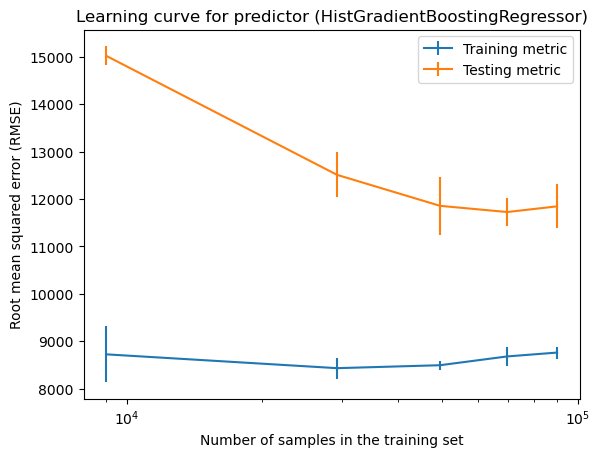

In [ ]:
import numpy as np

train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)
train_sizes

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

cv_sample = ShuffleSplit(n_splits=5, test_size=0.2)


display = LearningCurveDisplay.from_estimator(
    model_hist,
    data,
    target,
    train_sizes=train_sizes,
    cv=cv_sample,
    score_type="both",  # both train and test errors
    scoring="neg_root_mean_squared_error",
    negate_score=True,  # to use when metric starts with "neg_"
    log_scale=True,  # sets log scale for the x-axis
    score_name="Root mean squared error (RMSE)",
    std_display_style="errorbar",
    n_jobs=2,
)
_ = display.ax_.set_title("Learning curve for predictor (HistGradientBoostingRegressor)")